In [1]:
import numpy as np
import numpy.random as rnd
import time
import os

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Все места, где нужно дописать код отмечены TODO.

## Считывание и подготовка данных.

In [2]:
# Считываем текстовые данные: все файлы должны лежать в одной папке data. 
# Проверьте, что у вас все хорошо с кодировками и текст нормально считывается.
data = ""

for fname in os.listdir("data"):
    with open("data/"+fname) as fin:
        text = fin.read().decode('cp1251')
        data += text

In [3]:
# Для дальнейшей работы нам нужно текст перевести в числовой формат.
chars = list(set(data))
VOCAB_SIZE = len(chars)

char_to_id = { ch:id for id,ch in enumerate(chars) }
id_to_char = { id:ch for id,ch in enumerate(chars) }
data_ids = [char_to_id[ch] for ch in data]

## Вспомогательные функции

In [4]:
# Необходимые константы
NUM_EPOCHS = 10
NUM_BATCHES = 1000
BATCH_SIZE = 100
SEQ_LEN = 20
LEARNING_RATE = 0.001
GRAD_CLIP = 100

В процессе обучения мы будем для каждого символа входной последовательности предсказывать следующий символ. Таким образом на вход сети мы будем подавать последовательности длины SEQ_LEN и получать на выходе последовательности той же длины, но со сдвигом на один символ.

In [5]:
def generate_random_batch(source):
    """Функция, которая генерирует batch из BATCH_SIZE случайных подстрок текста source. 
    Каждая подстрока должна иметь длину SEQ_LEN.
    
    source - массив целых чисел - номеров символов в тексте (пример - data_ids)
    
    Вернуть нужно кортеж (X,y), где
    X - матрица, в которой каждая строка - подстрока длины SEQ_LEN (подается на вход сети)
    y - матрица, в которой каждая строка - подстрока длины SEQ_LEN, (ожидается на выходе сети)
    Таким образом, каждая строка в y должна соответсвовать строке в X со сдвигом на один символ вправо.
    Например, если X[0]='hell', то y[0]='ello'
    
    Убедитесь, что вы генерируете X и y, которые правильно соответствуют друг другу.
    Также убедитесь, что ваша функция не вылезает за край текста (самое начало или конец текста).
    """
    begins = np.random.choice(len(source) - SEQ_LEN - 1, BATCH_SIZE)
    
    X_batch = np.empty((BATCH_SIZE, SEQ_LEN), dtype=np.int)
    y_batch = np.empty((BATCH_SIZE, SEQ_LEN), dtype=np.int)
    for i, begin in enumerate(begins):
        X_batch[i, :] = source[begin: begin + SEQ_LEN]
        y_batch[i, :] = source[begin + 1: begin + SEQ_LEN + 1]
    
    return X_batch, y_batch

In [6]:
a,b = generate_random_batch(data_ids)
print ''.join(id_to_char[id] for id in a[0,:])
print ''.join(id_to_char[id] for id in b[0,:])

вляет или представля
ляет или представляе


В процессе тестирования мы будем предсказывать следующий символ по SEQ_LEN предыдущих. 
Генерировать очередной символ в тестовой посдедовательнсоти можно разными способами:
1. max_sample_fn: брать символ с максимальной вероятностью
2. proportional_sample_fn: генерировать символ пропорционально вероятности
3. alpha_sample_fn: генерировать символ пропорционально вероятности со следующей предобраоткой: 
    logprobs/alpha, где alpha - "жадность" из (0,1] - чем меньше, тем ближе генерация к выбору максимума
    после взятия экспоненты такие вероятности нужно перенормировать

Для устойчивости вычислений наша сеть будет выдавать не вероятности, а их логарифмы, поэтому не забывайте в нужных местах брать от них exp.

In [7]:
def max_sample_fn(logprobs):
    return np.argmax(logprobs)

def proportional_sample_fn(logprobs):
    probs = np.exp(logprobs)
    probs /= probs.sum()
    return np.random.choice(len(logprobs), p=probs)

def alpha_sample_fn(logprobs, alpha):
    probs = np.exp(logprobs / alpha)
    probs /= probs.sum()
    return np.random.choice(len(logprobs), p=probs)

def generate_seed():
    """Функция выбирает случайное начало поседовательности из data, 
    которую мы потом можем продолжать с помощью нейросети.
    """
    start = np.random.randint(0,len(data)-SEQ_LEN)
    seed_phrase = data[start:start+SEQ_LEN]
    return seed_phrase

def generate_sample(logprobs_fn,sample_fn,seed_phrase,N=100):
    """Функция генерирует случайный текст при помощи нейросети и печатает его
    
    logprobs_fn - функция, которая по входной последовательности длины SEQ_LEN 
        предсказывает логарифмы вероятностей посдледующего символа (см. функцию train)
    sample_fn - функция, выбирающая следующий символ одним из способов, описанных выше
    seed_phrase - начальная фраза, с которой мы начинаем генерировать
    N - размер генерируемого текста
    
    """
    random_snippet = seed_phrase
    for i in range(N):
        tmp = [char_to_id[ch] for ch in random_snippet[i:]]
        logprobs = logprobs_fn(tmp)
        random_snippet += id_to_char[sample_fn(logprobs)]
    
    print(random_snippet)

In [8]:
# Технические вещи

# Вспомогательная функция для запаковки результата обучения 
def pack(err, network, logprobs_fn):
    return {'err':err, 
        'network':network,
        'logprobs_fn':logprobs_fn
           } 

# numerically stable log-softmax with crossentropy
def logsoftmax(x):
    xdev = x-x.max(2,keepdim=True)[0]
    lsm = xdev - torch.exp(xdev).sum(dim=2, keepdim=True).log()
    return lsm

def lsmCE(x,y):
    return -torch.clamp(x,-20,0).gather(2, y.unsqueeze(2)).squeeze().mean()

## Нейронная сеть

In [60]:
class Net(nn.Module):
    """Класс задает простейшую рекуррентную сеть, которая принимает на вход батч размера [BATCH_SIZE, SEQ_LEN] 
    и применяет к нему следующие преобразования:
    
    1. Embedding для перевода кодировки символов в нормальное представление: VOCAB_SIZE -> emb_size
    2. Рекуррентный слой c n_hidden элементов на скрытом слое.
    3. Полносвязный слой n_hidden -> VOCAB_SIZE с logsoftmax в качестве нелинейности.
    
    В итоге на выход сеть должна возвращать ответ размера [BATCH_SIZE, SEQ_LEN, VOCAB_SIZE] 
    
    * Обратите внимание на параметр batch_first у рекуррентного слоя.
    """
    
    def __init__(self, emb_size=40, n_hidden=100, hidden_layers=1, net_type='RNN'):
        super(Net, self).__init__()
        
        self.encoder = nn.Embedding(VOCAB_SIZE, emb_size)

        if net_type == 'RNN':
            self.rnn = nn.RNN(emb_size, n_hidden, hidden_layers, batch_first=True)
        elif net_type == 'LSTM':
            self.rnn = nn.LSTM(emb_size, n_hidden, hidden_layers, batch_first=True)
        elif net_type == 'GRU':
            self.rnn = nn.GRU(emb_size, n_hidden, hidden_layers, batch_first=True)

        self.decoder = nn.Linear(n_hidden, VOCAB_SIZE)

    def forward(self, text):
        encoded = self.encoder(text)
        output, _ = self.rnn(encoded)
        decoded = self.decoder(output)
        return logsoftmax(decoded)

In [10]:
def train(data_ids, emb_size, n_hidden, show = False):
    """Функция обучает нейросеть по данным data_ids
    Следует обратить внимание на следующее:
    1. Сеть будем учить NUM_EPOCHS эпох, в каждой из которых будет NUM_BATCHES батчей
    2. Для того, чтобы следить за процессом обучения будем считать средний loss 
        на всех батчах в эпохе и сохранять его в массив err. Также будем генерировать 
        последовательности из случайных seeds после каждой эпохи, для этого нужна будет функция logprobs_fn,
        которая по входу х размера [1, SEQ_LEN] будет выдавать вектор логарифмов вероятностей 
        для последующего символа размера [1, VOCAB_SIZE]. 
        Например, если x='hell', то нас интересует каким будет символ после второго l. 
    3. Так как мы вместо softmax используем logsoftmax, то в качестве loss для сети нужно использовать lsmCE
    4. Перед тем, как делать шаг по градиенту, шрадиент нужно ограничивать по норме значением GRAD_CLIP
    
    * Если вы используете GPU, то не забудьте все данные и саму сеть перенести на GPU.
    """
    err=np.zeros(NUM_EPOCHS)

    print("Building network ...")
    net = Net(emb_size=emb_size, n_hidden=n_hidden)
    net.cuda()
    print("The network has {} params".format(sum([x.data.numel() for x in net.parameters()])))
    
    # Задаем оптимизатор, рекомендуется использовать adam
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    
    criterion = nn.CrossEntropyLoss()
        
    def logprobs_fn(snippetIdx):
        inp = Variable(torch.LongTensor([snippetIdx])).cuda()
        output = net(inp)
        return output[0, -1].cpu().data.numpy()
    
    def step():
        error = 0

        for batch in xrange(NUM_BATCHES):
            optimizer.zero_grad()
            
            X_, y_ = generate_random_batch(data_ids)
            X = Variable(torch.from_numpy(X_)).cuda()
            y = Variable(torch.from_numpy(y_)).cuda()
            
            output = net(X)
            
            loss = lsmCE(output, y)
            error += loss.data[0]
            
            loss.backward()
            nn.utils.clip_grad_norm(net.parameters(), GRAD_CLIP)
            optimizer.step()

        return error / NUM_BATCHES

    print("Training ...")
    for epoch in xrange(NUM_EPOCHS):
        start_time = time.time()
        err[epoch] = step()

        if show:
            seed = generate_seed()
            print "Seed: '{}'".format(seed.encode('utf-8'))
            print "Max sample:"
            generate_sample(logprobs_fn, max_sample_fn, seed)
            print ""
            print "Proportional sample:",
            generate_sample(logprobs_fn, proportional_sample_fn, seed)
        
        print("Epoch {} \t loss = {:.4f} \t time = {:.2f}s".
                      format(epoch, err[epoch], time.time() - start_time))

    return pack(err, net, logprobs_fn)

Перед тем, как запускать обучение с большим числом итераций и длинными последовательностями, попробуйте запустить его на десяток итераций с последовательнсотямит по 5 символов и проверьте, что у вас генерируются какие-то вменяемые слоги. При этом достатояно использовать довольно маленькую сеть.

In [11]:
model = train(data_ids, 40, 200, show=False)

Building network ...
The network has 72982 params
Training ...
Epoch 0 	 loss = 1.8732 	 time = 4.97s
Epoch 1 	 loss = 1.3803 	 time = 4.85s
Epoch 2 	 loss = 1.2842 	 time = 4.87s
Epoch 3 	 loss = 1.2375 	 time = 4.72s
Epoch 4 	 loss = 1.2106 	 time = 4.64s
Epoch 5 	 loss = 1.1908 	 time = 4.69s
Epoch 6 	 loss = 1.1793 	 time = 4.69s
Epoch 7 	 loss = 1.1690 	 time = 4.70s
Epoch 8 	 loss = 1.1593 	 time = 4.71s
Epoch 9 	 loss = 1.1538 	 time = 4.70s


## Посмотрим что из этого вышло

In [12]:
seed = u"Каждый человек должен"
alpha = 0.5
result_length = 300

generate_sample(model['logprobs_fn'],max_sample_fn,seed,result_length)

Каждый человек должен быть принятия представления в соответствии с законодательством Российской Федерации и принятия представления в соответствии с законодательством Российской Федерации и принятия представления в соответствии с законодательством Российской Федерации и принятия представления в соответствии с законодател


In [13]:
seed = u"Каждый человек должен"
alpha = 0.5
result_length = 300

generate_sample(model['logprobs_fn'],proportional_sample_fn,seed,result_length)

Каждый человек должен, автомотвыная доставки платежей недостатки по тевлужащей гражданин, предусмотренных лиц – от сем с порядка возмещаются права на принятии позвредующего госуданием деятельность последнего в дей, вправе (или) его его повых суда; на должностных лиц – узанными лица лиц, вопрова «умебен причиненного целе


In [14]:
seed = u"В случае неповиновения"
alpha = 0.5
sampling_fun = lambda x: alpha_sample_fn(x, alpha)
result_length = 300

generate_sample(model['logprobs_fn'],sampling_fun,seed,result_length)

В случае неповиновения и порядок подлежащего принятия решения и иного применение в деле, не противоречит в соответствии с правового средства, удостоверных владельцев таможенных пошлин, налогов в подлежат подрядчик в случае подание и находящихся в соответствии с правовыми актами арендодателя или иными отсутствии с нарушен


## Дополнительные пункты

1. Обучение более сложной модели и контроль переобучения. Попробуйте подобрать хорошую модель RNN для данной задачи. Для этого  проанализируйте качество работы модели в зависимости от ее размеров, попробуйте использовать многослойную сеть. Также нужно проконтролировать переобучение моделей. Для этого можно выделить тестовый кусок из текста и смотреть на то, как меняется loss на нем в процессе обучения. Если на графиках видно переобучение, то стоит добавить dropout в модель (обычный dropout до, между и после рекуррентных слоев). 
2. LSTM и GRU архитектуры. Вместо обычной RNN попробуйте LSTM и GRU архитектуры и сравните получающиеся результаты для моделей нескольких разных размеров. Также сравните модели на данных с разной SEQ_LEN. 
4. Визуализация. Попробуйте провизуализировать результаты. Например, можно смотреть на то, какие буквы модель хорошо предсказывает, а в каких сильно не уверена. Это покажет что именно выучила модель лучше всего. Также можно попробовать смотреть на активации разных скрытых нейронов при прочтении текста (как у Андрея Карпатого).
5. Более сложные данные. Попробуйте обучить модель на более структурированных данных, например коде. Используйте LSTM и GRU сети, они хорошо улавливают структуру в данных. Проанализируйте результаты: выделите нейроны, активации которых "отвечают" за структуру в данных. Этот пункт, пожалуй, стоит пробовать только если у вас есть нормальный GPU.
6. Продвинутый дропаут. Запрограммировать RNN/LSTM с продвинутым дропаутом из (одним из 3, обсужденных на лекции). Сравнить с обычным вариантом дропаута по нерекуррентным связям.

### Доп. пункт 1
Обучение более сложной модели и контроль переобучения. Попробуйте подобрать хорошую модель RNN для данной задачи. Для этого  проанализируйте качество работы модели в зависимости от ее размеров, попробуйте использовать многослойную сеть. Также нужно проконтролировать переобучение моделей. Для этого можно выделить тестовый кусок из текста и смотреть на то, как меняется loss на нем в процессе обучения. Если на графиках видно переобучение, то стоит добавить dropout в модель (обычный dropout до, между и после рекуррентных слоев). 

Напишем функцию обучения, которая будет делить выборку на train и test и считать loss на test

In [62]:
def train_control(data_ids, emb_size, n_hidden, hidden_layers=1, net_type='RNN', show=False):
    errTrain = np.zeros(NUM_EPOCHS)
    errTest = np.zeros(NUM_EPOCHS)

    print("Building network ...")
    net = Net(emb_size=emb_size, n_hidden=n_hidden, hidden_layers=hidden_layers, net_type=net_type)
    net.cuda()
    print("The network has {} params".format(sum([x.data.numel() for x in net.parameters()])))
    
    # Задаем оптимизатор, рекомендуется использовать adam
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    
    criterion = nn.CrossEntropyLoss()
    
    edgeTrain = int(0.6 * len(data_ids))
    data_train, data_test = data_ids[:edgeTrain], data_ids[edgeTrain:]
        
    def logprobs_fn(snippetIdx):
        inp = Variable(torch.LongTensor([snippetIdx])).cuda()
        output = net(inp)
        return output[0, -1].cpu().data.numpy()
    
    def step():
        errorTrain = 0
        errorTest = 0

        for batch in xrange(NUM_BATCHES):
            optimizer.zero_grad()
            
            X_, y_ = generate_random_batch(data_train)
            X = Variable(torch.from_numpy(X_)).cuda()
            y = Variable(torch.from_numpy(y_)).cuda()
            
            output = net(X)
            
            loss = lsmCE(output, y)
            errorTrain += loss.data[0]
            
            loss.backward()
            nn.utils.clip_grad_norm(net.parameters(), GRAD_CLIP)
            optimizer.step()
            
            X_, y_ = generate_random_batch(data_test)
            X = Variable(torch.from_numpy(X_)).cuda()
            y = Variable(torch.from_numpy(y_)).cuda()
            
            output = net(X)
            loss = lsmCE(output, y)
            errorTest += loss.data[0]

        return errorTrain / NUM_BATCHES, errorTest / NUM_BATCHES

    print("Training ...")
    for epoch in xrange(NUM_EPOCHS):
        start_time = time.time()
        errTrain[epoch], errTest[epoch] = step()

        if show:
            seed = generate_seed()
            print "Seed: '{}'".format(seed.encode('utf-8'))
            print "Max sample:"
            generate_sample(logprobs_fn, max_sample_fn, seed)
            print ""
            print "Proportional sample:",
            generate_sample(logprobs_fn, proportional_sample_fn, seed)
        
        print("Epoch {} \t train loss = {:.4f} \t test loss = {:.4f} \t time = {:.2f}s".
                      format(epoch, errTrain[epoch], errTest[epoch], time.time() - start_time))

    return pack({'train': errTrain, 'test': errTest}, net, logprobs_fn)

In [24]:
NUM_EPOCHS = 25

Обучим модель с разными конфигурациями. Было решено менять количество нейронов в скрытом слое и количество скрытых слоев.

In [25]:
%%time
models = {}
for h_layer in [3, 4, 5]:
    for n_hidden in [50, 200, 350]:
        print h_layer, n_hidden
        models[(h_layer, n_hidden)] = train_control(data_ids, 40, n_hidden=n_hidden, hidden_layers=h_layer)
        print '\n'

3 50
Building network ...
The network has 24082 params
Training ...
Epoch 0 	 train loss = 2.1970 	 test loss = 2.2808 	 time = 7.65s
Epoch 1 	 train loss = 1.5749 	 test loss = 1.7304 	 time = 7.60s
Epoch 2 	 train loss = 1.4514 	 test loss = 1.6309 	 time = 7.60s
Epoch 3 	 train loss = 1.3939 	 test loss = 1.5830 	 time = 7.63s
Epoch 4 	 train loss = 1.3608 	 test loss = 1.5583 	 time = 7.63s
Epoch 5 	 train loss = 1.3392 	 test loss = 1.5410 	 time = 7.69s
Epoch 6 	 train loss = 1.3212 	 test loss = 1.5254 	 time = 7.65s
Epoch 7 	 train loss = 1.3084 	 test loss = 1.5176 	 time = 7.63s
Epoch 8 	 train loss = 1.2979 	 test loss = 1.5093 	 time = 7.64s
Epoch 9 	 train loss = 1.2851 	 test loss = 1.5047 	 time = 7.63s
Epoch 10 	 train loss = 1.2791 	 test loss = 1.4976 	 time = 7.70s
Epoch 11 	 train loss = 1.2728 	 test loss = 1.4935 	 time = 7.61s
Epoch 12 	 train loss = 1.2673 	 test loss = 1.4868 	 time = 7.63s
Epoch 13 	 train loss = 1.2630 	 test loss = 1.4846 	 time = 7.63s
Epoc

Epoch 18 	 train loss = 0.9447 	 test loss = 1.2308 	 time = 11.11s
Epoch 19 	 train loss = 0.9430 	 test loss = 1.2262 	 time = 11.10s
Epoch 20 	 train loss = 0.9414 	 test loss = 1.2267 	 time = 11.11s
Epoch 21 	 train loss = 0.9376 	 test loss = 1.2256 	 time = 11.10s
Epoch 22 	 train loss = 0.9383 	 test loss = 1.2264 	 time = 11.11s
Epoch 23 	 train loss = 0.9389 	 test loss = 1.2254 	 time = 11.13s
Epoch 24 	 train loss = 0.9388 	 test loss = 1.2250 	 time = 11.10s


4 350
Building network ...
The network has 914182 params
Training ...
Epoch 0 	 train loss = 1.7847 	 test loss = 1.9197 	 time = 15.90s
Epoch 1 	 train loss = 1.1653 	 test loss = 1.3726 	 time = 15.86s
Epoch 2 	 train loss = 1.0807 	 test loss = 1.3075 	 time = 15.87s
Epoch 3 	 train loss = 1.0428 	 test loss = 1.2795 	 time = 15.84s
Epoch 4 	 train loss = 1.0194 	 test loss = 1.2639 	 time = 15.85s
Epoch 5 	 train loss = 1.0024 	 test loss = 1.2491 	 time = 15.88s
Epoch 6 	 train loss = 0.9898 	 test loss = 1.2440

In [32]:
import matplotlib.pyplot as plt

Нарисуем ошибки на train и test для каждой конфигурации сети

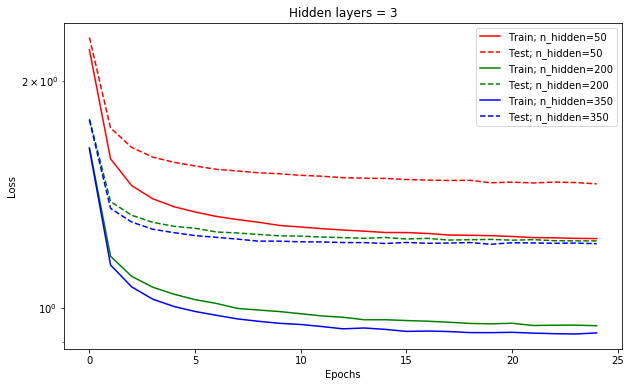

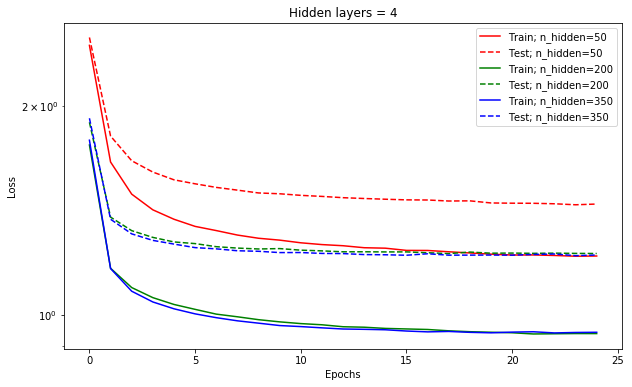

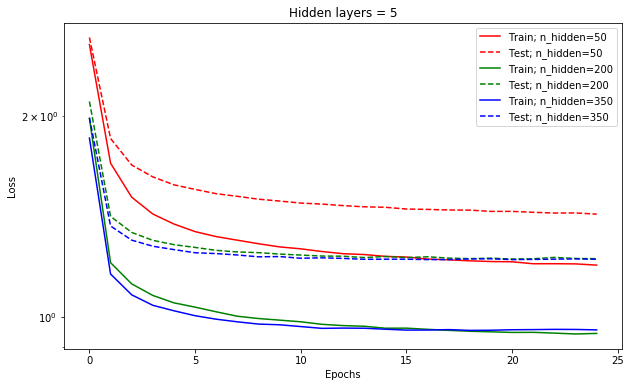

In [85]:
c = ['r', 'g', 'b']
for h_layer in [3, 4, 5]:
    i = 0

    plt.figure(figsize=(10, 6))
    plt.title('Hidden layers = {}'.format(h_layer))
    for n_hidden in [50, 200, 350]:
        model = models[(h_layer, n_hidden)]
        plt.semilogy(model['err']['train'], c=c[i], label='Train; n_hidden={}'.format(n_hidden))
        plt.semilogy(model['err']['test'], '--', c=c[i], label='Test; n_hidden={}'.format(n_hidden))

        i += 1
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

По графикам видно, что быстрее сходится модель с большим количеством нейронов на скрытом слое. Теперь сравним конфигурации по количеству скрытых слоев.

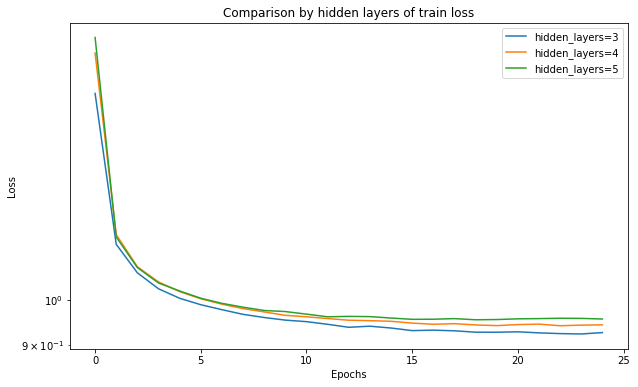

In [86]:
n_hidden = 350
plt.figure(figsize=(10, 6))
plt.title('Comparison by hidden layers of train loss')

for h_layer in [3, 4, 5]:
    model = models[(h_layer, n_hidden)]
    plt.semilogy(model['err']['train'], label='hidden_layers={}'.format(h_layer))

plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

##### Выводы

Путем подбора было найдено, что при больших количествах нейронов скрытого слоя (в эксперименте 350) сеть достигает минимальный loss и на train и на test. Также из поледнего графика видно, что особой разницы в глубине сети (количество скрытых слоев) нет. Таким образом, для данной задачи сеть должна быть не слишком глубокой для быстрого обучения, но с дотаточным количеством нейронов для лучшей сходимости.

Также из всех графиков с test loss видно, что нету переобучения. По крайней мере при данном количестве эпох. В связи с этим нет необходимости в добавлении dropout.

### Доп. пункт 2
LSTM и GRU архитектуры. Вместо обычной RNN попробуйте LSTM и GRU архитектуры и сравните получающиеся результаты для моделей нескольких разных размеров. Также сравните модели на данных с разной SEQ_LEN. 

Обучим три модели с разным числом нейронов на скрытом слое.

In [67]:
%%time
models_type = {}
for model_name in ['RNN', 'GRU', 'LSTM']:
    for n_hidden in [50, 200, 350]:
        print model_name, n_hidden
        models_type[(model_name, n_hidden)] = train_control(data_ids, 40, n_hidden=n_hidden, net_type=model_name)
        print '\n'

RNN 50
Building network ...
The network has 13882 params
Training ...
Epoch 0 	 train loss = 2.3095 	 test loss = 2.3754 	 time = 5.79s
Epoch 1 	 train loss = 1.7997 	 test loss = 1.9224 	 time = 6.31s
Epoch 2 	 train loss = 1.6837 	 test loss = 1.8240 	 time = 5.69s
Epoch 3 	 train loss = 1.6283 	 test loss = 1.7838 	 time = 5.55s
Epoch 4 	 train loss = 1.5964 	 test loss = 1.7595 	 time = 5.38s
Epoch 5 	 train loss = 1.5760 	 test loss = 1.7451 	 time = 5.44s
Epoch 6 	 train loss = 1.5628 	 test loss = 1.7311 	 time = 5.36s
Epoch 7 	 train loss = 1.5436 	 test loss = 1.7230 	 time = 5.35s
Epoch 8 	 train loss = 1.5401 	 test loss = 1.7134 	 time = 5.35s
Epoch 9 	 train loss = 1.5306 	 test loss = 1.7134 	 time = 5.33s
Epoch 10 	 train loss = 1.5309 	 test loss = 1.7124 	 time = 5.47s
Epoch 11 	 train loss = 1.5188 	 test loss = 1.7050 	 time = 5.36s
Epoch 12 	 train loss = 1.5182 	 test loss = 1.7065 	 time = 5.36s
Epoch 13 	 train loss = 1.5140 	 test loss = 1.7030 	 time = 5.36s
Ep

Epoch 18 	 train loss = 0.9873 	 test loss = 1.2597 	 time = 8.30s
Epoch 19 	 train loss = 0.9855 	 test loss = 1.2549 	 time = 8.33s
Epoch 20 	 train loss = 0.9838 	 test loss = 1.2528 	 time = 8.36s
Epoch 21 	 train loss = 0.9816 	 test loss = 1.2525 	 time = 8.32s
Epoch 22 	 train loss = 0.9795 	 test loss = 1.2534 	 time = 8.35s
Epoch 23 	 train loss = 0.9769 	 test loss = 1.2517 	 time = 8.34s
Epoch 24 	 train loss = 0.9766 	 test loss = 1.2543 	 time = 8.34s


GRU 350
Building network ...
The network has 451482 params
Training ...
Epoch 0 	 train loss = 1.6362 	 test loss = 1.7873 	 time = 12.22s
Epoch 1 	 train loss = 1.1314 	 test loss = 1.3535 	 time = 12.15s
Epoch 2 	 train loss = 1.0560 	 test loss = 1.2935 	 time = 12.17s
Epoch 3 	 train loss = 1.0157 	 test loss = 1.2634 	 time = 12.16s
Epoch 4 	 train loss = 0.9910 	 test loss = 1.2486 	 time = 12.14s
Epoch 5 	 train loss = 0.9760 	 test loss = 1.2345 	 time = 12.13s
Epoch 6 	 train loss = 0.9630 	 test loss = 1.2287 	 ti

Нарисуем полученные ошибки

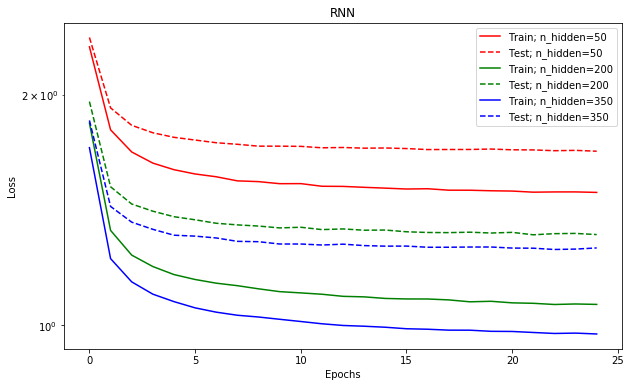

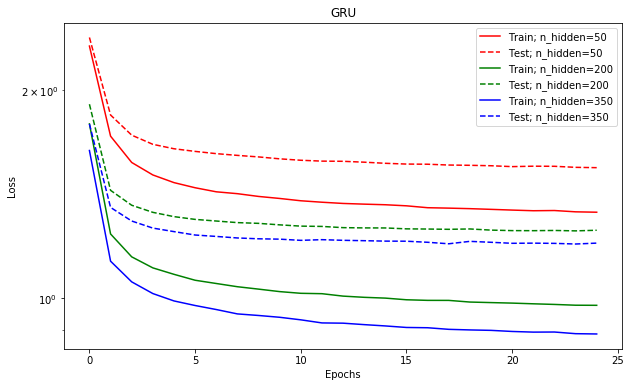

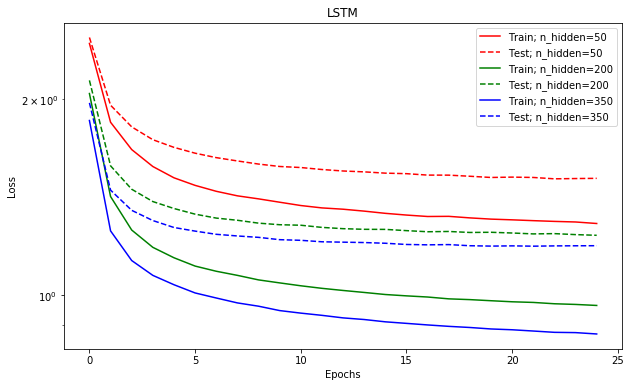

In [87]:
c = ['r', 'g', 'b']
for model_name in ['RNN', 'GRU', 'LSTM']:
    i = 0

    plt.figure(figsize=(10, 6))
    plt.title(model_name)
    for n_hidden in [50, 200, 350]:
        model = models_type[(model_name, n_hidden)]
        plt.semilogy(model['err']['train'], c=c[i], label='Train; n_hidden={}'.format(n_hidden))
        plt.semilogy(model['err']['test'], '--', c=c[i], label='Test; n_hidden={}'.format(n_hidden))

        i += 1
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

Для всех моделей ситуация с количеством нейронов в скрытом слое такая же, как и для RNN: чем больше нейронов, тем быстрее сходимость. Теперь сравним скорость сходимости:

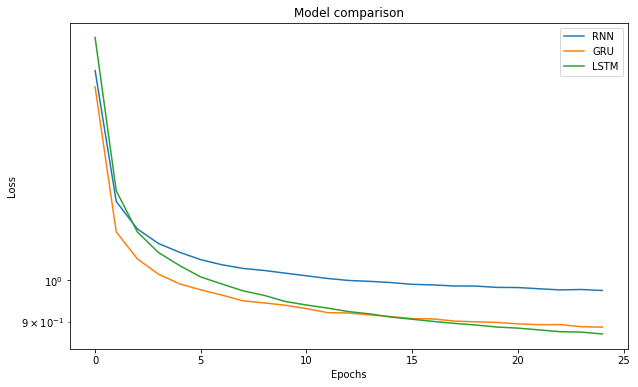

In [88]:
n_hidden = 350
plt.figure(figsize=(10, 6))
plt.title('Model comparison')

for model_name in ['RNN', 'GRU', 'LSTM']:
    model = models_type[(model_name, n_hidden)]
    plt.semilogy(model['err']['train'], label='{}'.format(model_name))

plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

По графикам видно, что скорость сходимости LSTM выше чем у остальных моделей, хотя на начальных эпохах GRU сходился быстрее.

Теперь сравним выводы моделей для одного и того же seed и сравним "на глаз"

In [81]:
n_hidden = 350
seed = u"В случае неповиновения"
alpha = 0.5
sampling_fun = lambda x: alpha_sample_fn(x, alpha)
result_length = 300

for model_name in ['RNN', 'GRU', 'LSTM']:
    print model_name
    model = models_type[(model_name, n_hidden)]
    generate_sample(model['logprobs_fn'],sampling_fun,seed,result_length)
    print '\n'

RNN
В случае неповиновения объектов – лесной информации, а также при уплаты таможенных пошлин, налогов в соответствии с федеральным законом от 21.07.2005 №93-ФЗ) 
 влечет наложение административного штрафа в размере от десяти до двадцати до двадцати минимальных размеров оплаты труда.

 Статья 12.
 33. Нарушение правила н


GRU
В случае неповиновения исполнительного листа на принудительное исполнение решения в связи с использованием для проведения таможенного органа или его должностного лица или страховой организационно-процессуальных средств в соответствии с настоящим Кодексом и иными правовыми актами Российской Федерации и вывоз перевозки и п


LSTM
В случае неповиновения в соответствии с законодательством Российской Федерации.

 Статья 77.
 Предмет залога в области таможенного дела, вправе выдвинения в области таможенного дела, по правилам государственном регулировании внешнеторговой деятельности на срок до девяноста суток; на юридических лиц – от пяти до десяти




Из сгенерированных выше текстов видно, что LSTM и GRU отрабатывают лучше, т.к. текст более осмысленный и структурированный, тогда как RNN генерить тексты с некотрой ошибкой склонения и т.п. Но так как LSTM сходится быстрее, то сравним работу модели в зависимости от SEQ_LEN

In [82]:
lstm_res = {}
for SEQ_LEN in [10, 50, 100]:
    print SEQ_LEN
    lstm_res[SEQ_LEN] = train_control(data_ids, 40, n_hidden=350, net_type='LSTM')
    print '\n'

10
Building network ...
The network has 588682 params
Training ...
Epoch 0 	 train loss = 1.9691 	 test loss = 2.0734 	 time = 8.74s
Epoch 1 	 train loss = 1.4274 	 test loss = 1.5922 	 time = 8.87s
Epoch 2 	 train loss = 1.3219 	 test loss = 1.5046 	 time = 8.50s
Epoch 3 	 train loss = 1.2720 	 test loss = 1.4672 	 time = 8.66s
Epoch 4 	 train loss = 1.2411 	 test loss = 1.4382 	 time = 8.85s
Epoch 5 	 train loss = 1.2206 	 test loss = 1.4219 	 time = 8.44s
Epoch 6 	 train loss = 1.2052 	 test loss = 1.4063 	 time = 8.40s
Epoch 7 	 train loss = 1.1923 	 test loss = 1.4063 	 time = 8.40s
Epoch 8 	 train loss = 1.1828 	 test loss = 1.3946 	 time = 8.36s
Epoch 9 	 train loss = 1.1771 	 test loss = 1.3880 	 time = 8.41s
Epoch 10 	 train loss = 1.1680 	 test loss = 1.3829 	 time = 8.36s
Epoch 11 	 train loss = 1.1625 	 test loss = 1.3792 	 time = 8.41s
Epoch 12 	 train loss = 1.1583 	 test loss = 1.3717 	 time = 8.39s
Epoch 13 	 train loss = 1.1536 	 test loss = 1.3739 	 time = 8.38s
Epoch

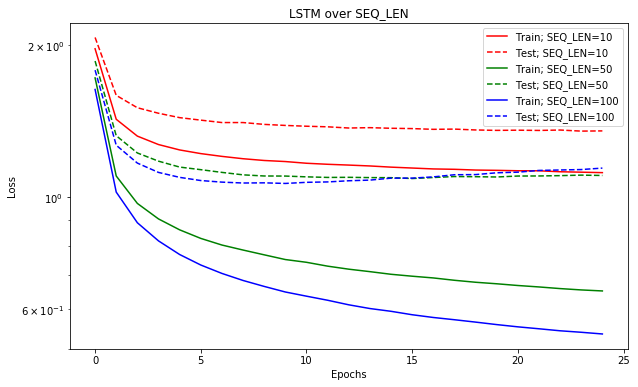

In [84]:
plt.figure(figsize=(10, 6))
plt.title('LSTM over SEQ_LEN')

for i, seq_len in enumerate([10, 50, 100]):
    model = lstm_res[seq_len]
    plt.semilogy(model['err']['train'], c=c[i], label='Train; SEQ_LEN={}'.format(seq_len))
    plt.semilogy(model['err']['test'], '--', c=c[i], label='Test; SEQ_LEN={}'.format(seq_len))

plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Из графика выше видно, что с увеличением SEQ_LEN модель начинает переобучаться. Далее сравним, какие ответы нам выдадут модели

In [90]:
n_hidden = 350
seed = u"В случае неповиновения"
alpha = 0.5
sampling_fun = lambda x: alpha_sample_fn(x, alpha)
result_length = 300

for i, seq_len in enumerate([10, 50, 100]):
    print 'SEQ_LEN =', seq_len
    model = lstm_res[seq_len]
    generate_sample(model['logprobs_fn'],sampling_fun,seed,result_length)
    print '\n'

SEQ_LEN = 10
В случае неповиновения обязательства о соглашение правил охраны проведения имущества, находящиеся на заключения таможенного дельных средств извещения при принятии товаров под таможенным режимом судебного акта постольку, предусмотренных настоящим Кодексом.
 3. К правового акта, подлежащих предусмотренных настоящей статьи


SEQ_LEN = 50
В случае неповиновения в соответствии с пунктом 1 настоящей статьи.
 2. Заявление об отказе в принятии к рассмотрению жалобы о признании несоответствующими Конституции РФ см. Постановление Конституционного Суда РФ от 12.04.1999 №2-П. 
 2. В случае предупреждения или без таковой; на юридических лиц – от двухсот до трехс


SEQ_LEN = 100
В случае неповиновения в области таможенного дела, в целях проверки товаров и (или) транспортных средств.
 3. При отсутствии нарушения заявленного способа идентификации в соответствии с остальным судом первой инстанции по автомагистрали бенефициара принять на возмещение вреда.
 2. По мотивированному запросу заин

Интересным является тот факт, что с увеличением SEQ_LEN улучшается смысл текста и в целом текст более похож на обучающую выборку, что подтверждает переобучение.

##### Выводы

Для генерации текста лучшим себя показал LSTM и по скорости сходимости и выделению основной структуры текста. Также увеличение SEQ_LEN ведет к переобучению, что логично, т.к. мы берем больше кусков обучающего текста.

# С новым годом!